### Idea

### Inverness

In [3]:
import inverness
model = inverness.Model('model_all/').load()

load done in 12.12 seconds


### Standard imports

In [4]:
from IPython.core.display import display, HTML
from matplotlib import pyplot as plt
from tqdm import tqdm
import pandas as pd
import re
pd.set_option('display.max_rows', 100)

### Helper functions


In [104]:
def score_text(text, criteria):
    """"""
    total = 0
    value = 1
    for c in criteria:
        if type(c) in (int,float):
            value = c
        else:
            c = c.replace('_',r'\b')
            matches = re.findall(c,text,re.I)
            total += value if matches else 0
            #total += value*len(matches)
    return total


def score_results(i_d_lists, criteria, mark=None):
    """"""
    results = []
    for i,d in zip(*i_d_lists):
        doc = model.get_doc(i)
        text = model.doc_to_text(doc).replace('\n',' ').replace('\r',' ')
        s = score_text(text, criteria)
        text = highlight(text, criteria, mark)
        rec = s,d,i,text,doc
        results += [rec]
    results.sort(key=lambda x:(-x[0],x[1]))
    return results


def score_queries(queries, criteria, N=50):
    """"""
    by_score = []
    for query in queries:
        q = model.text_to_dense(query)
        i_d = model.dense_ann_query(q,N)
        results = score_results(i_d, criteria)
        score = agg_results(results)
        by_score += [(score,query)]
    by_score.sort()
    return by_score

# TODO styles: mark_color/bold/text_color
def highlight(text, criteria, mark=None):
    """"""
    group_id = 0
    for c in criteria:
        if type(c) in (int,float):
            group_id += 1
        else:
            c = c.replace('_',r'\b')
            c = f'({c}\\w*)'
            if mark and group_id in mark:
                text = re.sub(c, '<mark style="background-color: #FFFF00">\\1</mark>', text, flags=re.I)
            else:
                text = re.sub(c, '<b>\\1</b>', text, flags=re.I)
    return text


# L2 score
def agg_results(results):
    """"""
    scores = [x[0] for x in results]
    return sum([x*x for x in scores])**0.5


# TODO break title into multiple lines
def plot_results(results,title=''):
    """"""
    scores = [x[0] for x in results]
    scores.sort(reverse=True)
    plt.plot(scores)
    if title: plt.title(title)
    score = agg_results(results)
    plt.figtext(0.4, 1, f"L2 score: {score:.02f}")
    plt.show()

# TEST
highlight("this is a test of this function",['thi',5,'_is'],mark=[1])

'<b>this</b> <mark style="background-color: #FFFF00">is</mark> a test of <b>this</b> function'

# Outcomes data for COVID-19 after mechanical ventilation adjusted for age

### Scoring criteria

In [83]:
criteria = [
    5,'mechanical','ventilat',
    2,'adjust','_age','years','_old',
    2,'surviv','discharge','extubate','died','dead','death','mortality','Kaplan-Meier',
    1,'duration','_day','\d+ patients',
    2,'figure','table',
]

# TODO criteria display style
mark = [2,3]

### Query selection


In [78]:
queries = [
        'results after mechnical ventilation discharged dead died',
        'results after mechnical ventilation discharged dead died survived survivors adjusted age years old',
        'results after mechnical ventilation discharged died survived survivors extubated adjusted',
        'results after mechnical ventilation discharged dead died survived survivors adjusted age years old',
        'results after mechnical ventilation discharged died survived extubated adjusted',
        'results after mechnical ventilation discharged died survived extubated adjusted age',
        'outcomes after mechnical ventilation discharged died survived extubated adjusted',
        'results outcomes after mechnical ventilation discharged died survived extubated adjusted age',
        'results outcomes after mechnical ventilation discharged died survived extubated adjusted',
]

for score,query in score_queries(queries, criteria, 50):
    print(f"{score:10.02f} -- {query}")

     44.31 -- results after mechnical ventilation discharged dead died survived survivors adjusted age years old
     44.31 -- results after mechnical ventilation discharged dead died survived survivors adjusted age years old
     94.86 -- results after mechnical ventilation discharged died survived extubated adjusted age
    104.51 -- results after mechnical ventilation discharged dead died
    110.89 -- results outcomes after mechnical ventilation discharged died survived extubated adjusted age
    116.46 -- results after mechnical ventilation discharged died survived extubated adjusted
    119.23 -- results after mechnical ventilation discharged died survived survivors extubated adjusted
    119.60 -- outcomes after mechnical ventilation discharged died survived extubated adjusted
    123.27 -- results outcomes after mechnical ventilation discharged died survived extubated adjusted


### Final query

In [90]:
query = 'results outcomes after mechnical ventilation \n discharged died survived extubated adjusted'

### Query the model

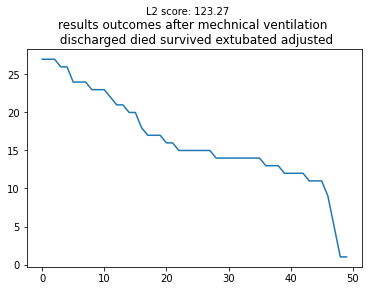

In [107]:
K = 50
q = model.text_to_dense(query)
i_d_lists = model.dense_ann_query(q, K)
results = score_results(i_d_lists, criteria, mark)
plot_results(results, title=query)

### Display results

In [106]:
N = 10
for s,d,i,text,doc in results[:N]:
    display(HTML(f"{s} :: {d:.03f} :: {i}<br>{text}"))